# Cosinor Regression Model used for 24-hours Window Analysis

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.ma import add
from CosinorPy import file_parser, cosinor, cosinor1, cosinor_nonlin
np.seterr(divide='ignore')
import scipy.signal as signal
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as multi
from scipy.optimize import curve_fit
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy.stats import percentileofscore
from scipy.stats import circstd, circmean

import copy
import itertools
from random import sample
import os
import copy
from CosinorPy.helpers import df_add_row

### Data Preparation

In [13]:
def load_data(path):
    """Function used to parser the data using the file_parser method from the CosinorPy package"""
    df = pd.read_csv(path)
    df['Region start time'] = pd.to_datetime(df['Region start time'])
    df['date'] = df['Region start time'].dt.date
    df['hour'] = df['Region start time'].dt.hour
    df = df.drop('Unnamed: 0', axis=1)
    return df

In [14]:
pre_data = load_data("data/RNS_G_Pre_output.csv")
post_data = load_data("data/RNS_G_M1_output.csv")

In [15]:
def prepare_data(df):
    """Function used to prepare the data for Cosinor Regression"""
    df1 = df.copy()
    df1["test"] = df1["date"].astype(str)
    df1["x"] = df1["hour"]
    df1["y"] = df1["Pattern A Channel 2"]
    
    return df1

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))
/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))
/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))
/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))
/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))
/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: inv

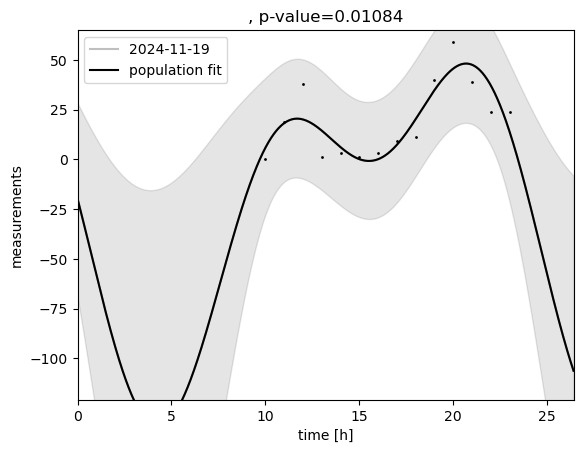

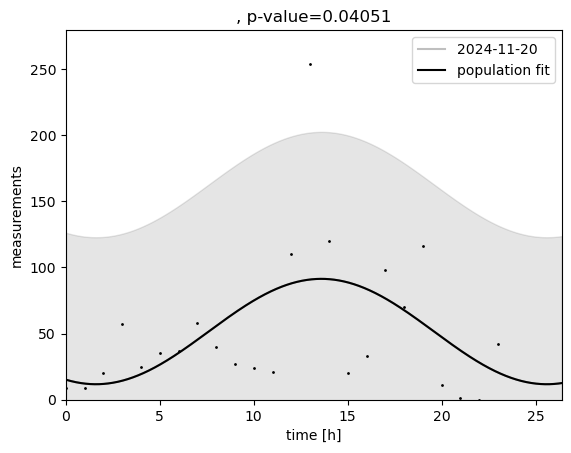

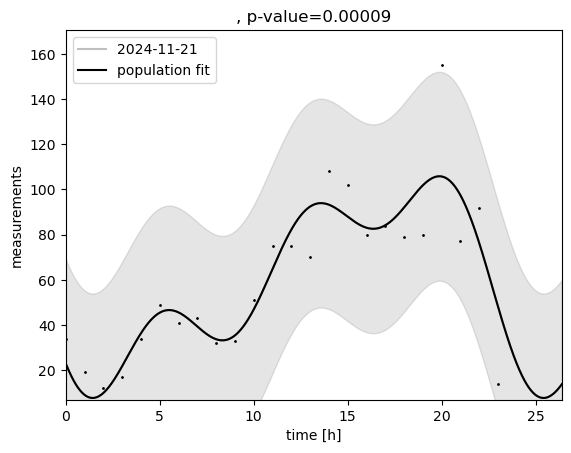

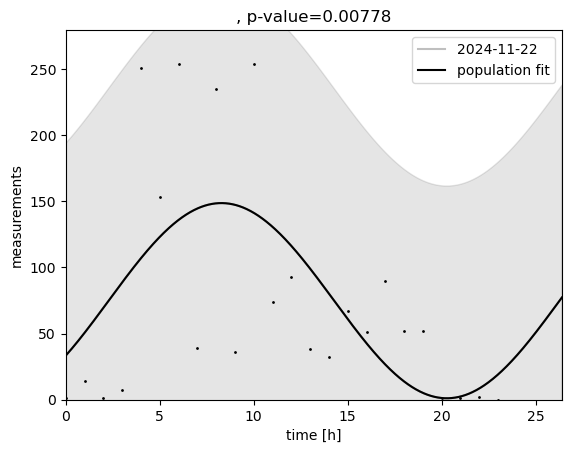

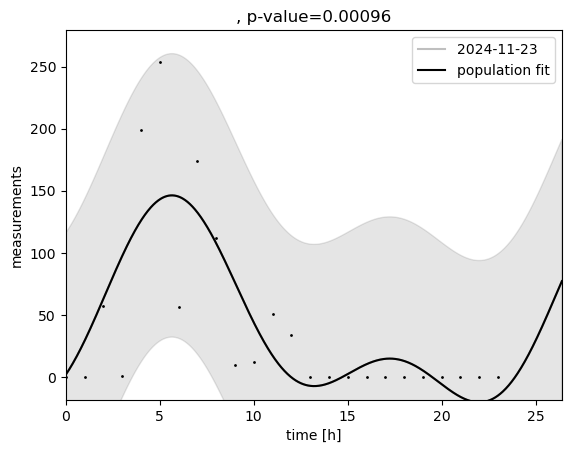

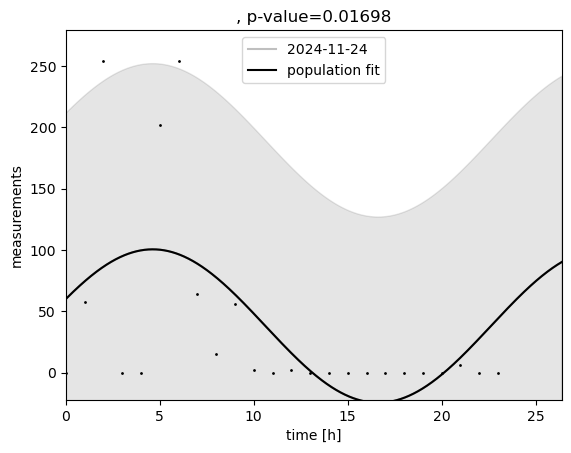

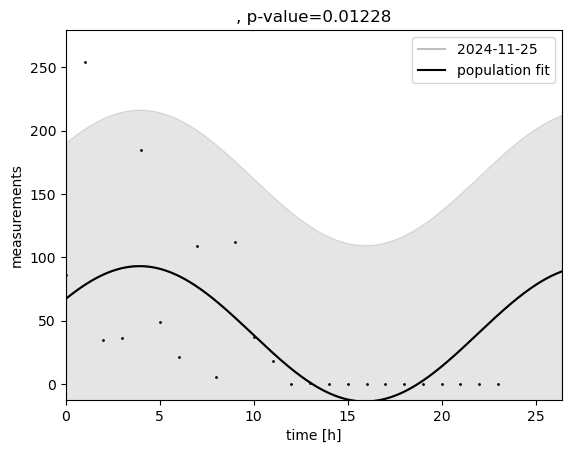

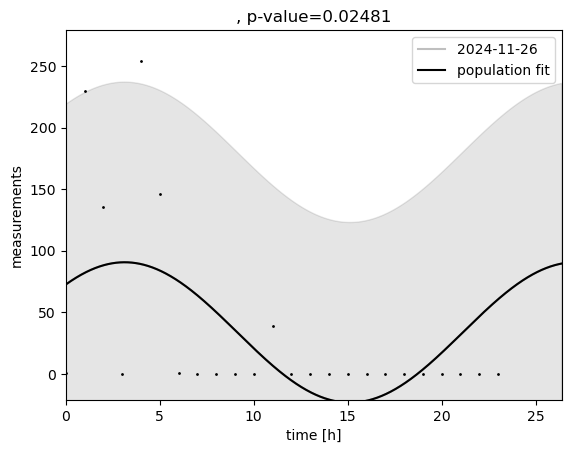

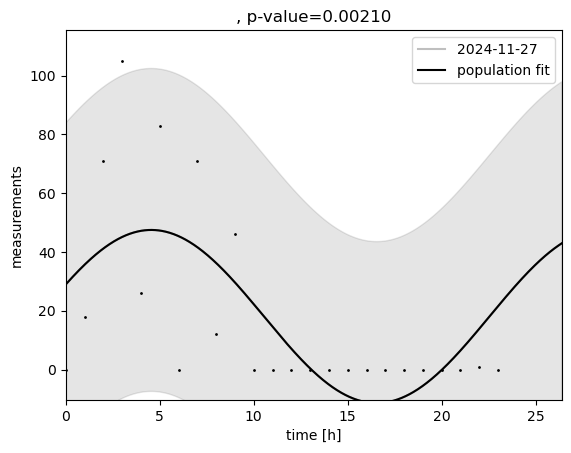

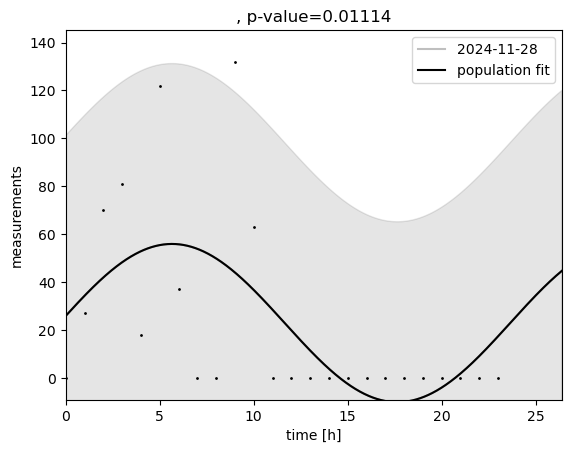

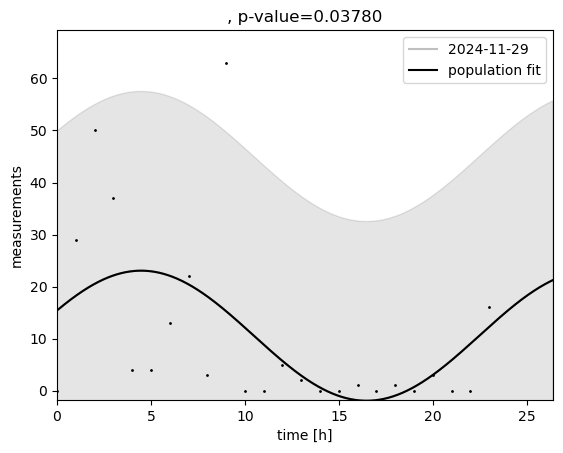

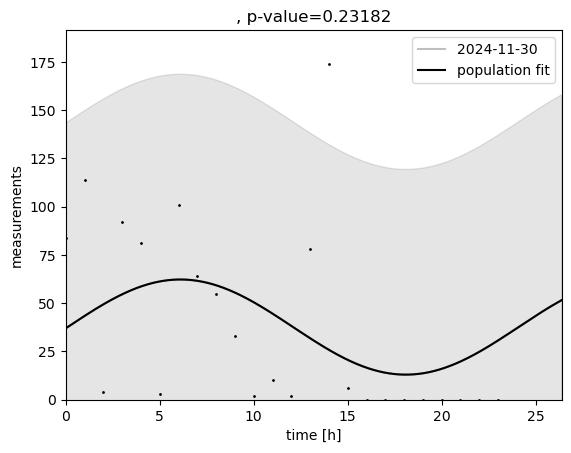

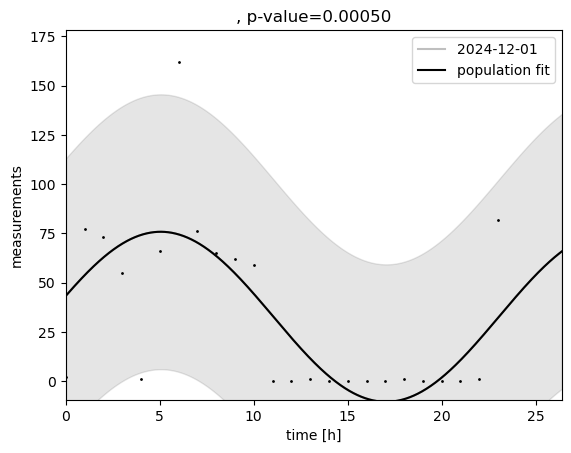

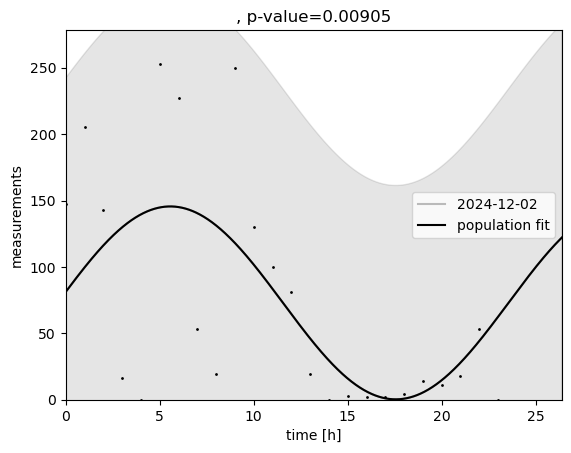

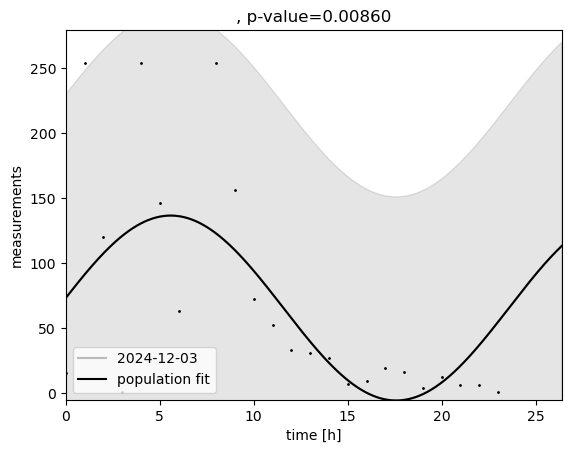

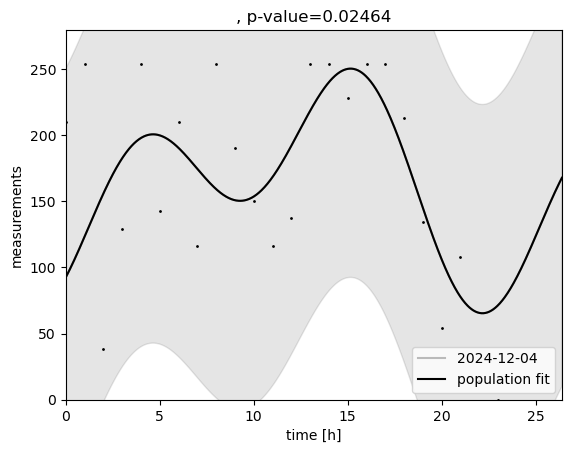

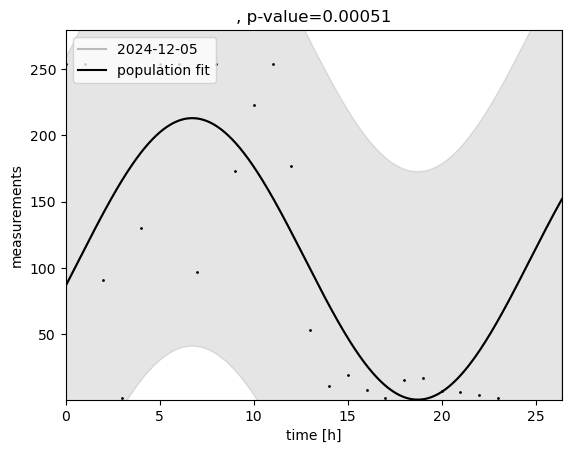

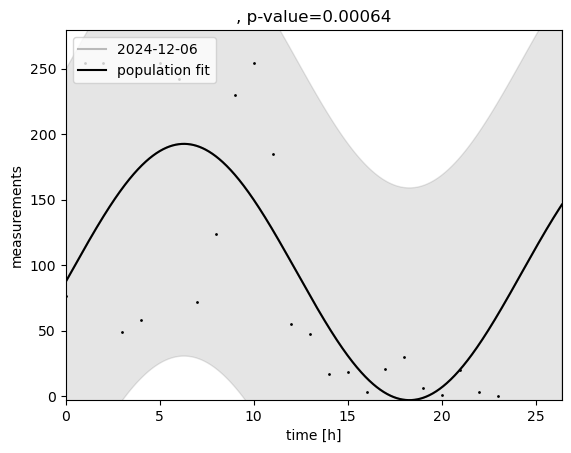

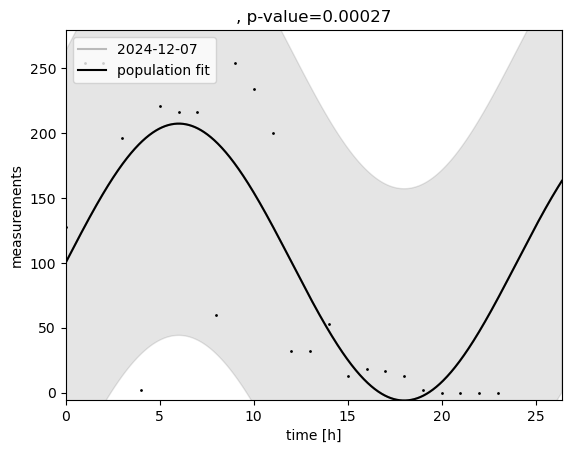

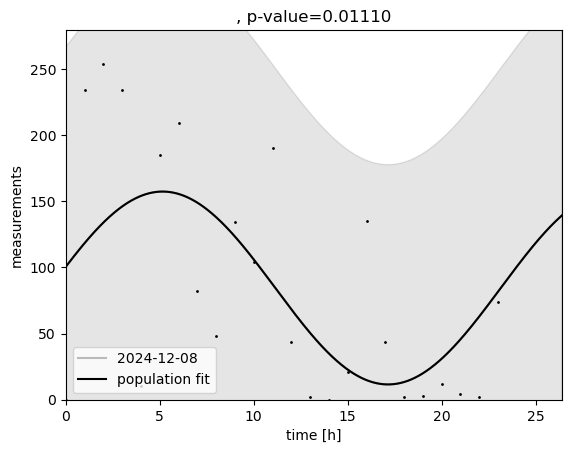

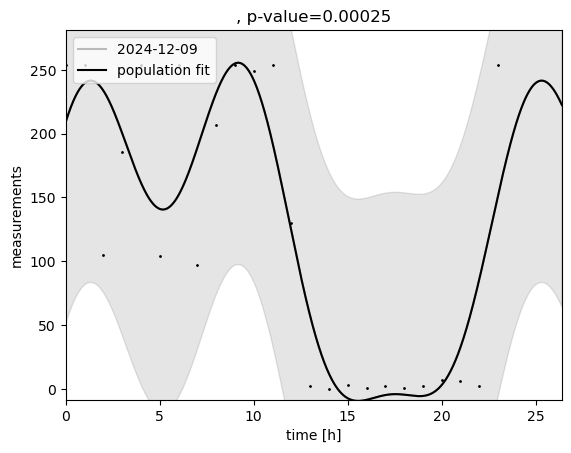

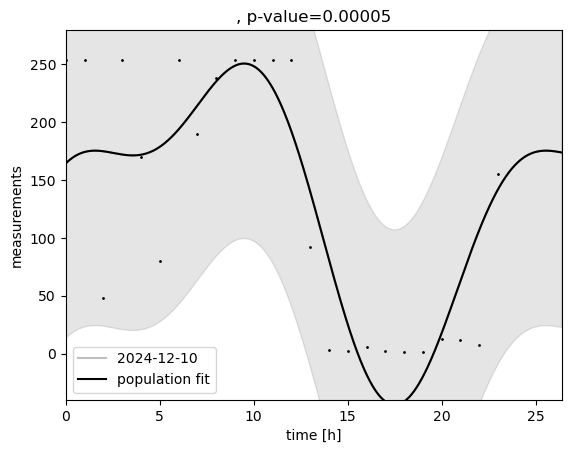

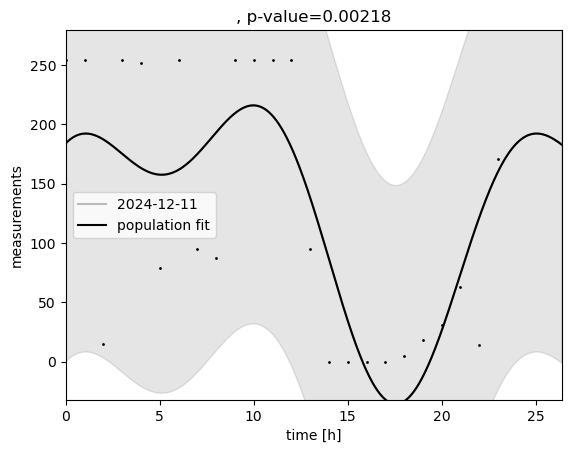

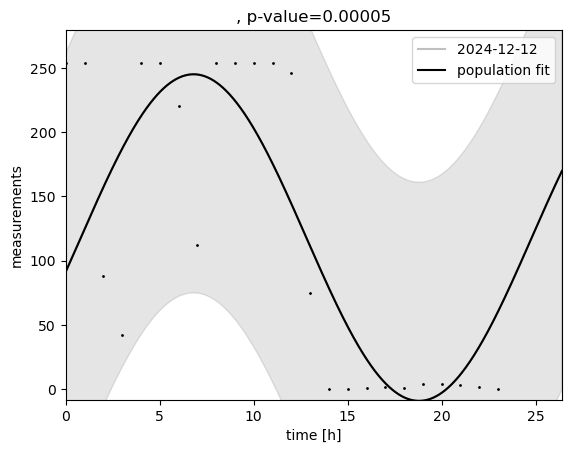

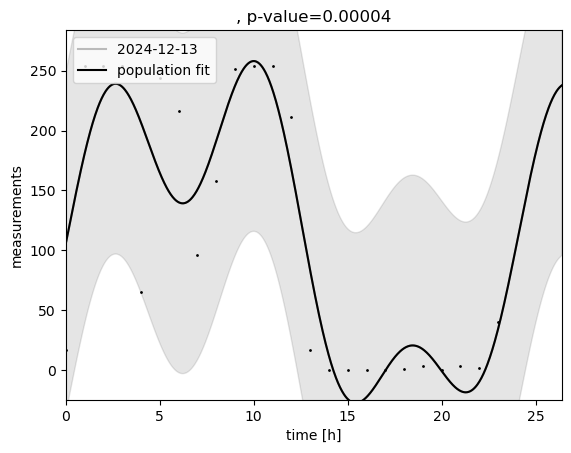

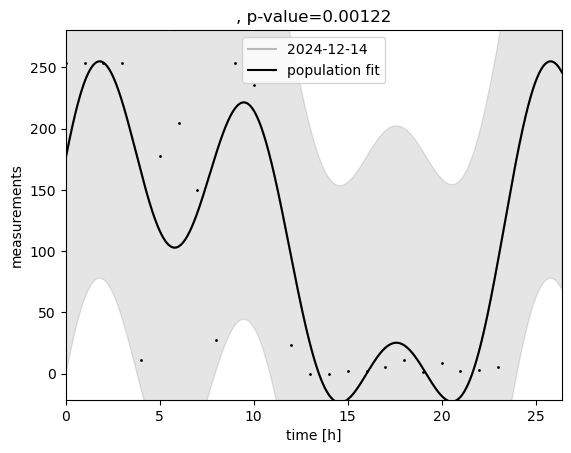

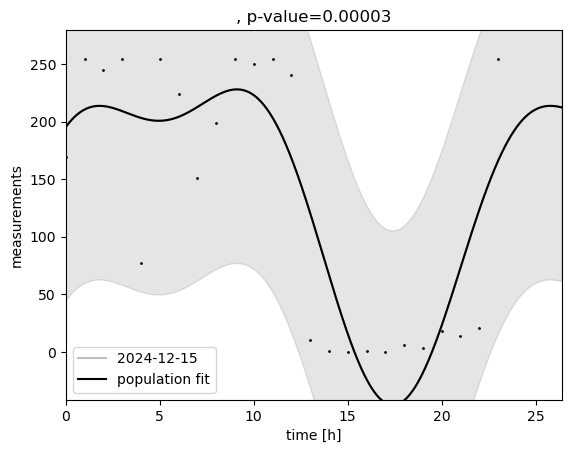

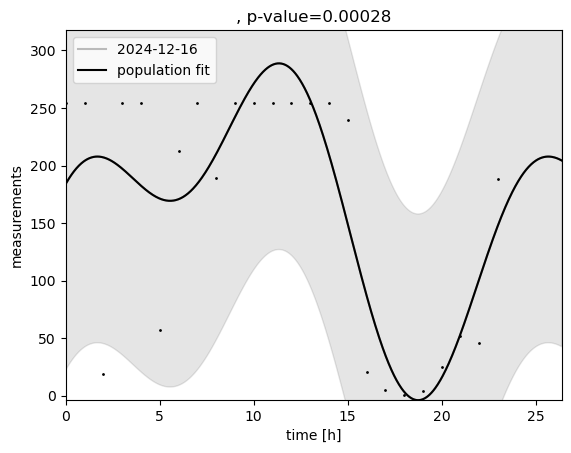

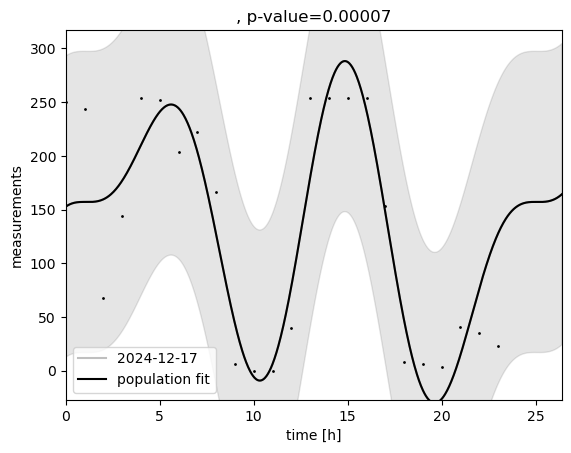

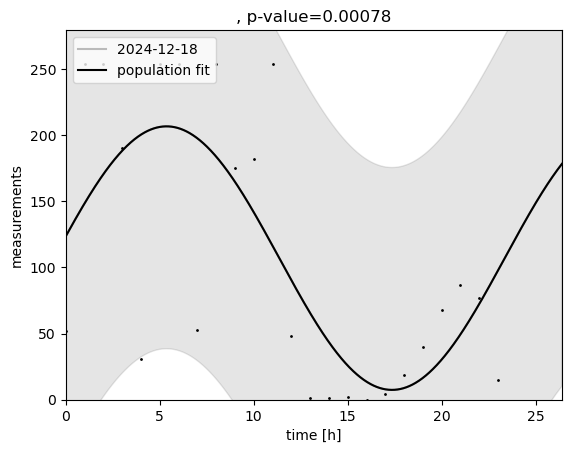

,test,period,n_components,p,q,p_reject,q_reject,RSS,amplitude,acrophase,...,resid_SE,mean(amplitude),p(amplitude),CI(amplitude),mean(acrophase),p(acrophase),CI(acrophase),mean(mesor),p(mesor),CI(mesor)
0,2024-11-19,24.0,2.0,0.010843,0.017594,NaN,NaN,1199.428355,91.121130,0.874237,...,11.544255,91.121130,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",0.874237,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-43.011645,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
1,2024-11-20,24.0,1.0,0.040513,0.051755,NaN,NaN,53300.623356,39.825930,2.723343,...,50.379807,39.825930,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",2.723343,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",51.541748,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
2,2024-11-21,24.0,3.0,0.000092,0.000826,NaN,NaN,6316.739215,49.053231,1.075500,...,19.276226,49.053231,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",1.075500,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",56.777238,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
3,2024-11-22,24.0,1.0,0.007780,0.014587,NaN,NaN,111065.890155,73.773555,-2.163579,...,72.724493,73.773555,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-2.163579,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",74.874840,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
4,2024-11-23,24.0,2.0,0.000956,0.003324,NaN,NaN,46777.337439,83.312033,-1.471737,...,49.618194,83.312033,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-1.471737,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",62.988380,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
5,2024-11-24,24.0,1.0,0.016978,0.025468,NaN,NaN,99010.060345,62.555815,-1.207579,...,68.664145,62.555815,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-1.207579,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",38.041600,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
6,2024-11-25,24.0,1.0,0.012284,0.019061,NaN,NaN,65900.712274,53.461203,-1.031474,...,56.019007,53.461203,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-1.031474,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",39.499990,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
7,2024-11-26,24.0,1.0,0.024808,0.036012,NaN,NaN,92557.525291,57.051108,-0.817632,...,66.389014,57.051108,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-0.817632,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",33.625108,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
8,2024-11-27,24.0,1.0,0.002100,0.005772,NaN,NaN,13032.058474,29.457408,-1.195000,...,24.911327,29.457408,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-1.195000,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",18.041706,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
9,2024-11-28,24.0,1.0,0.011143,0.017594,NaN,NaN,24472.488716,33.019294,-1.484316,...,34.137320,33.019294,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-1.484316,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",22.916742,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"


In [16]:
df_results_pre_data = cosinor.population_fit_group(prepare_data(pre_data), n_components = [1,2,3], period=24, plot=False)
df_best_models_pre_data = cosinor.get_best_models_population(prepare_data(pre_data), df_results_pre_data, n_components = [1,2,3])
cosinor.plot_df_models_population(prepare_data(pre_data), df_best_models_pre_data)
df_best_models_pre_data

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))
/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))
/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))
/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))
/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))
/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: inv

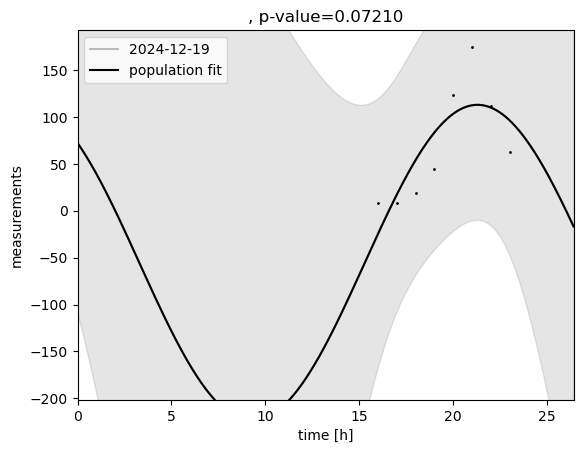

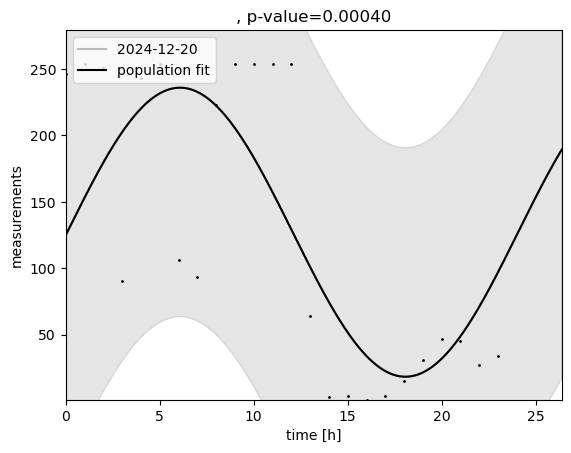

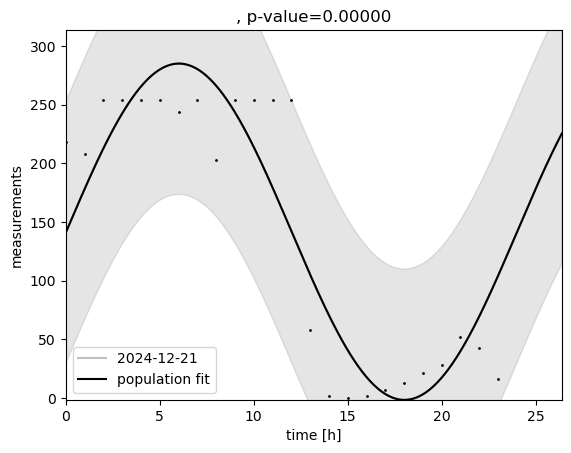

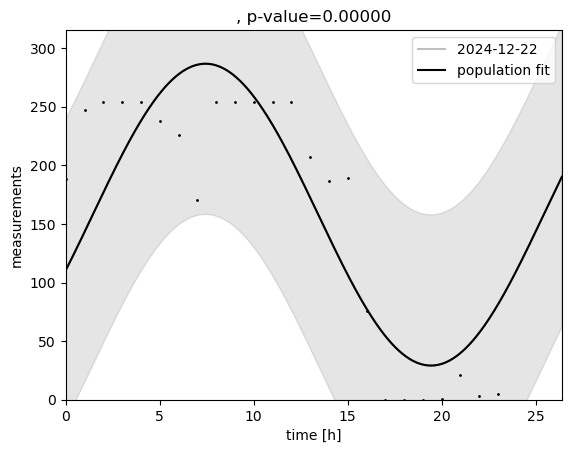

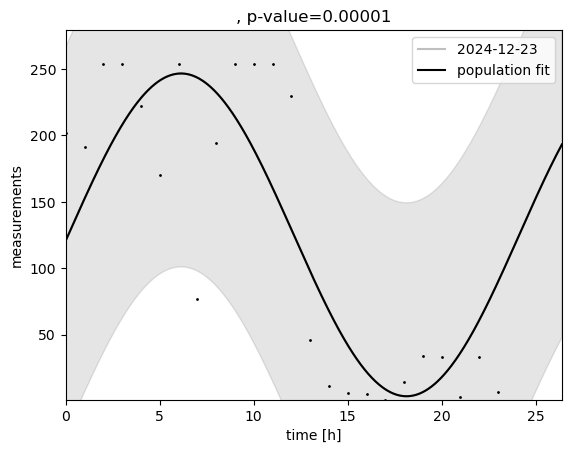

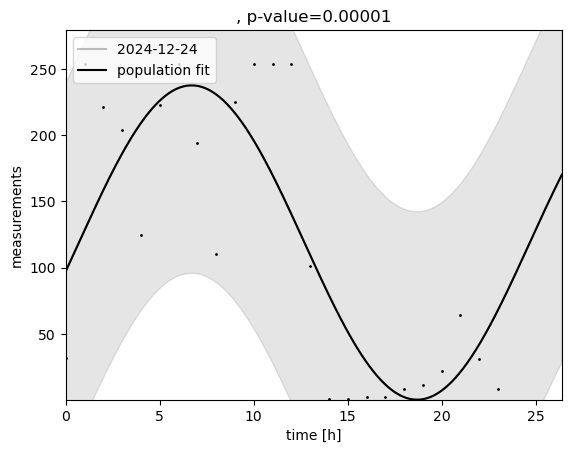

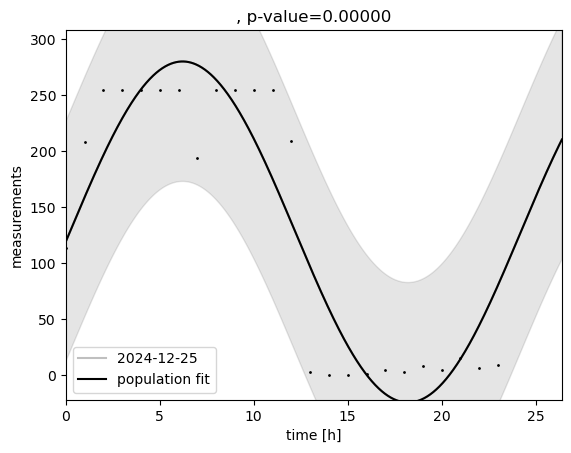

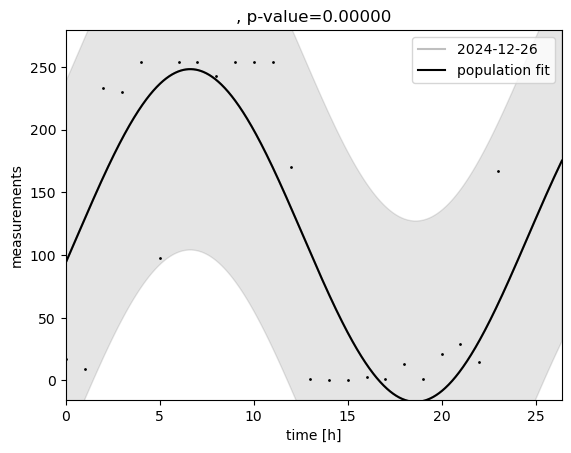

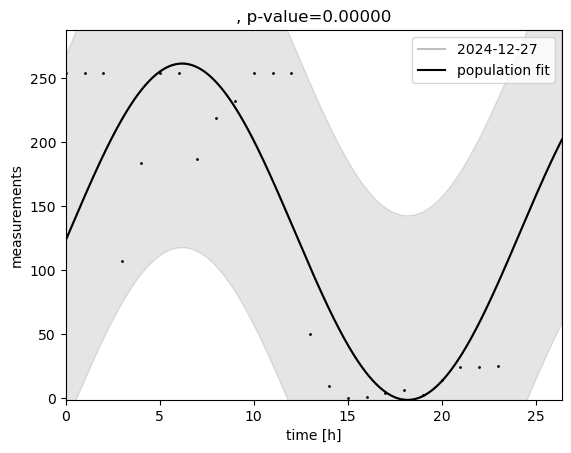

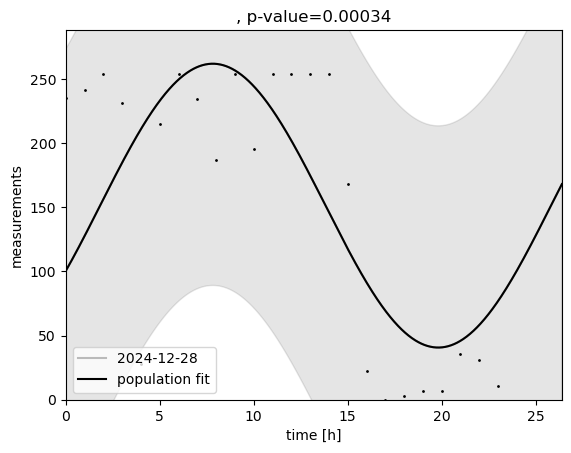

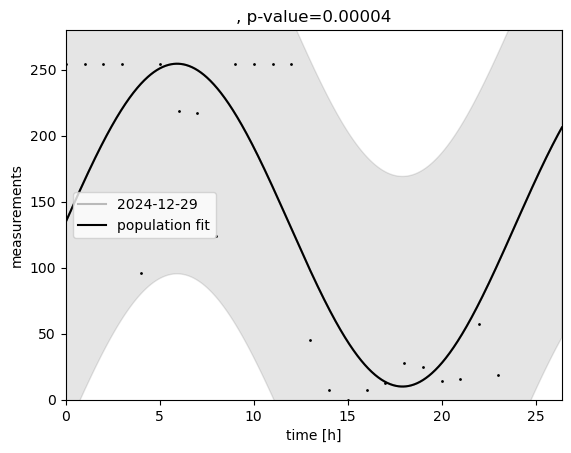

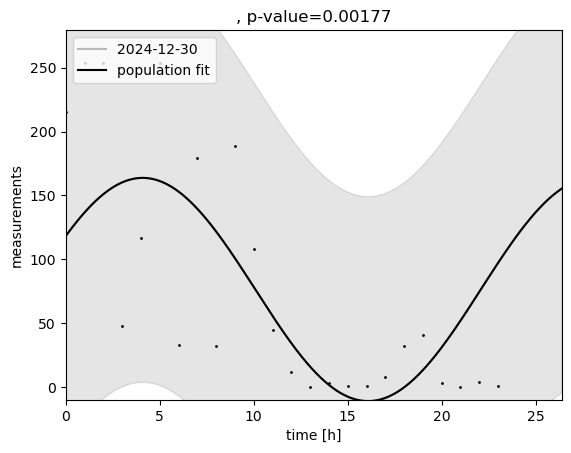

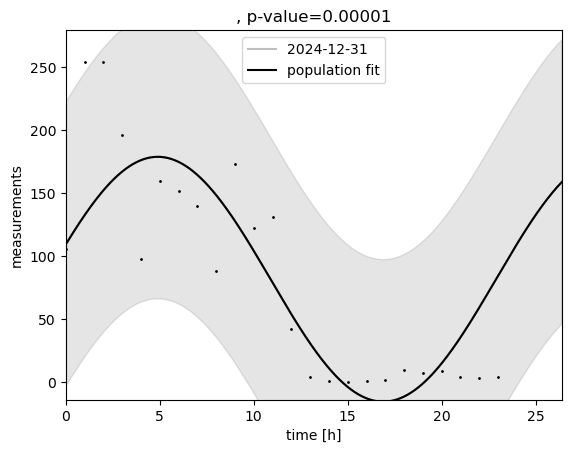

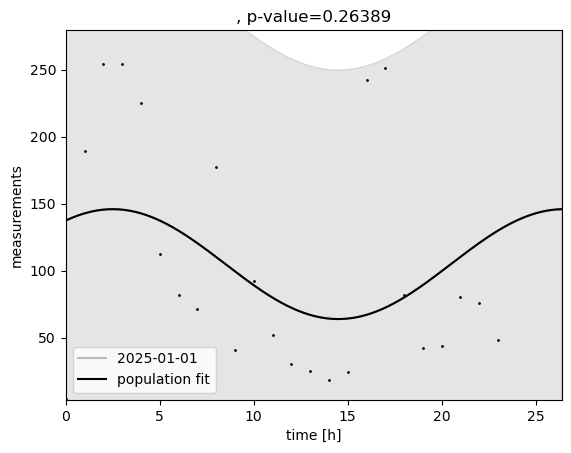

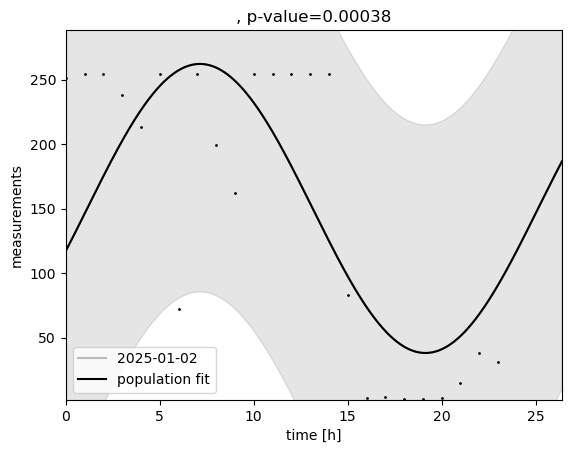

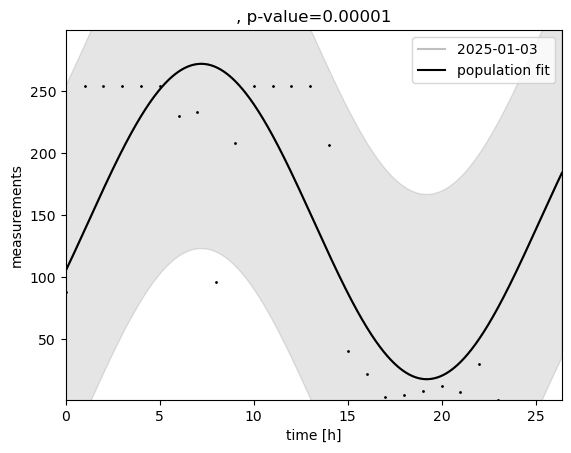

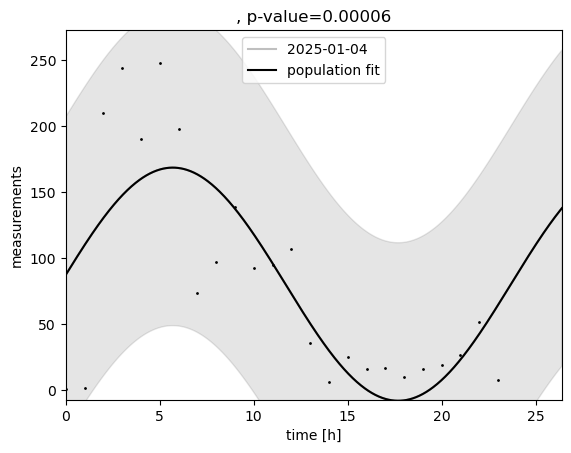

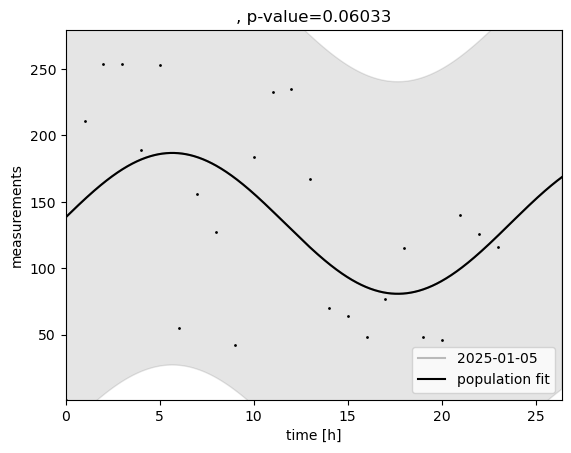

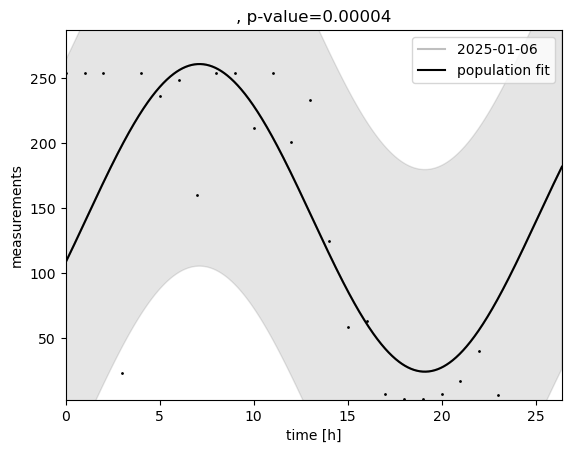

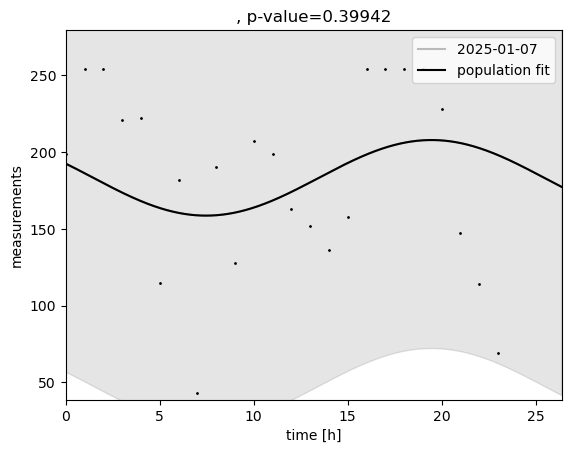

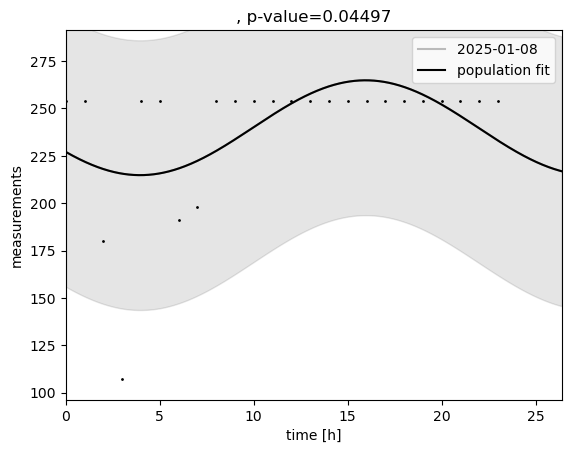

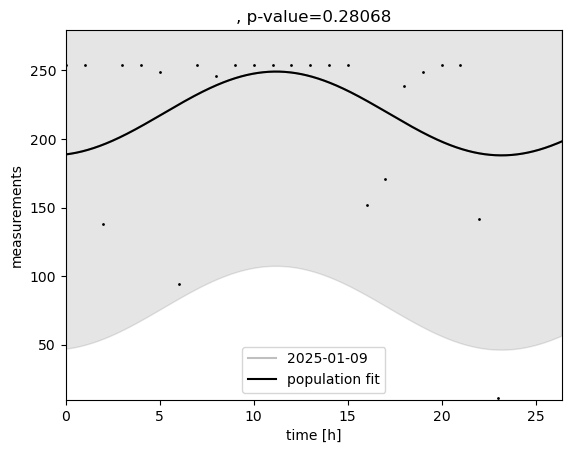

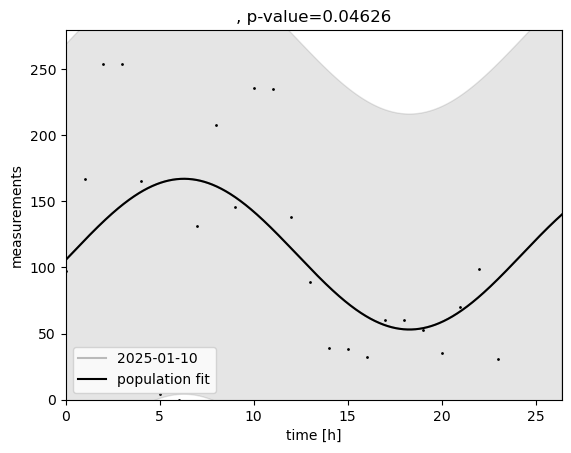

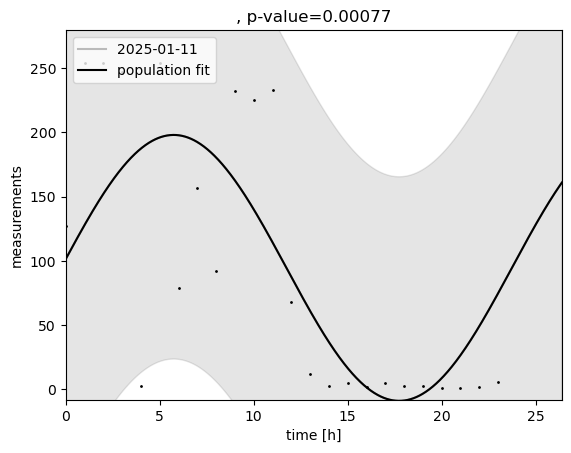

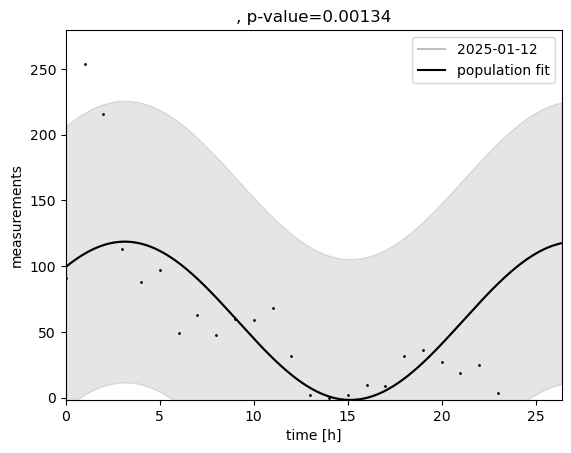

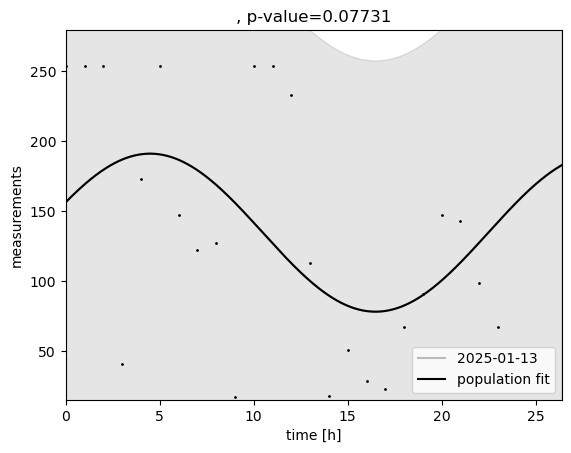

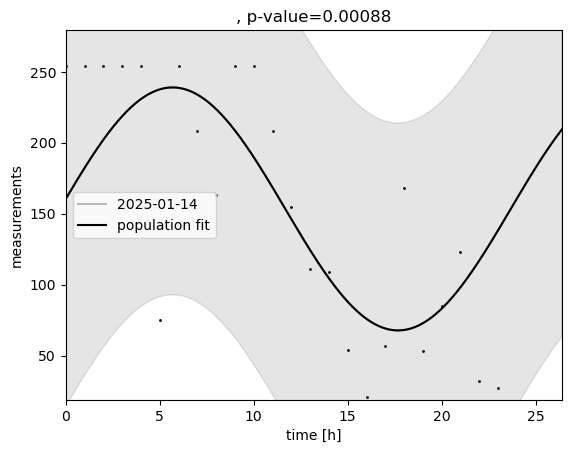

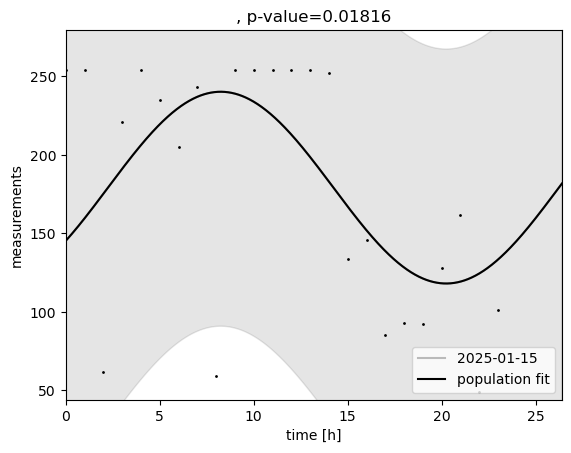

,test,period,n_components,p,q,p_reject,q_reject,RSS,amplitude,acrophase,...,resid_SE,mean(amplitude),p(amplitude),CI(amplitude),mean(acrophase),p(acrophase),CI(acrophase),mean(mesor),p(mesor),CI(mesor)
0,2024-12-19,24.0,1.0,7.210367e-02,8.052395e-02,NaN,NaN,9275.284076,168.328715,0.710711,...,43.070371,168.328715,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",0.710711,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-55.445181,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
1,2024-12-20,24.0,1.0,4.011205e-04,7.324809e-04,NaN,NaN,128649.633130,108.900036,-1.584948,...,78.269873,108.900036,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-1.584948,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",127.124928,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
2,2024-12-21,24.0,1.0,1.424462e-08,2.393096e-07,NaN,NaN,53657.952009,143.234155,-1.572369,...,50.548398,143.234155,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-1.572369,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",141.708177,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
3,2024-12-22,24.0,1.0,8.483388e-07,5.938372e-06,NaN,NaN,71409.444279,128.769105,-1.949737,...,58.313375,128.769105,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-1.949737,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",157.916517,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
4,2024-12-23,24.0,1.0,1.231184e-05,4.924736e-05,NaN,NaN,91713.426508,121.604747,-1.610106,...,66.085596,121.604747,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-1.610106,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",125.125195,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
5,2024-12-24,24.0,1.0,1.195565e-05,4.924736e-05,NaN,NaN,87034.899348,118.713786,-1.748474,...,64.377939,118.713786,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-1.748474,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",118.958200,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
6,2024-12-25,24.0,1.0,2.413220e-09,6.757016e-08,NaN,NaN,49494.106629,152.217027,-1.622684,...,48.547525,152.217027,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-1.622684,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",127.624663,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
7,2024-12-26,24.0,1.0,3.041685e-06,1.703344e-05,NaN,NaN,89751.451934,132.656572,-1.735895,...,65.374909,132.656572,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-1.735895,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",115.624693,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
8,2024-12-27,24.0,1.0,3.403526e-06,1.786851e-05,NaN,NaN,89593.647655,131.530537,-1.622684,...,65.317411,131.530537,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-1.622684,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",129.999695,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
9,2024-12-28,24.0,1.0,3.412417e-04,6.666117e-04,NaN,NaN,128804.390890,110.563329,-2.050369,...,78.316936,110.563329,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-2.050369,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",151.208126,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"


In [17]:
df_results_post_data = cosinor.population_fit_group(prepare_data(post_data), n_components = [1,2,3], period=24, plot=False)
df_best_models_post_data = cosinor.get_best_models_population(prepare_data(pre_data), df_results_post_data, n_components = [1,2,3])
cosinor.plot_df_models_population(prepare_data(post_data), df_best_models_post_data)
df_best_models_post_data

### Statistics Analysis

This section includes the plots and analysis for the test statistics derived from the population cosinor fitting process.

In [18]:
df_best_models_pre_data
df_best_models_post_data
test_statistics = pd.concat([df_best_models_pre_data, df_best_models_post_data], axis=0, ignore_index=True)
test_statistics

,test,period,n_components,p,q,p_reject,q_reject,RSS,amplitude,acrophase,...,resid_SE,mean(amplitude),p(amplitude),CI(amplitude),mean(acrophase),p(acrophase),CI(acrophase),mean(mesor),p(mesor),CI(mesor)
0,2024-11-19,24.0,2.0,1.084326e-02,1.759444e-02,NaN,NaN,1199.428355,91.121130,0.874237,...,11.544255,91.121130,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",0.874237,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-43.011645,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
1,2024-11-20,24.0,1.0,4.051311e-02,5.175452e-02,NaN,NaN,53300.623356,39.825930,2.723343,...,50.379807,39.825930,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",2.723343,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",51.541748,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
2,2024-11-21,24.0,3.0,9.175531e-05,8.257978e-04,NaN,NaN,6316.739215,49.053231,1.075500,...,19.276226,49.053231,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",1.075500,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",56.777238,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
3,2024-11-22,24.0,1.0,7.779767e-03,1.458706e-02,NaN,NaN,111065.890155,73.773555,-2.163579,...,72.724493,73.773555,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-2.163579,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",74.874840,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
4,2024-11-23,24.0,2.0,9.559492e-04,3.324057e-03,NaN,NaN,46777.337439,83.312033,-1.471737,...,49.618194,83.312033,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-1.471737,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",62.988380,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
5,2024-11-24,24.0,1.0,1.697843e-02,2.546765e-02,NaN,NaN,99010.060345,62.555815,-1.207579,...,68.664145,62.555815,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-1.207579,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",38.041600,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
6,2024-11-25,24.0,1.0,1.228361e-02,1.906078e-02,NaN,NaN,65900.712274,53.461203,-1.031474,...,56.019007,53.461203,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-1.031474,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",39.499990,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
7,2024-11-26,24.0,1.0,2.480818e-02,3.601188e-02,NaN,NaN,92557.525291,57.051108,-0.817632,...,66.389014,57.051108,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-0.817632,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",33.625108,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
8,2024-11-27,24.0,1.0,2.099507e-03,5.772362e-03,NaN,NaN,13032.058474,29.457408,-1.195000,...,24.911327,29.457408,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-1.195000,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",18.041706,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"
9,2024-11-28,24.0,1.0,1.114314e-02,1.759444e-02,NaN,NaN,24472.488716,33.019294,-1.484316,...,34.137320,33.019294,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",-1.484316,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]",22.916742,NaN,"[nan, <function nan_to_num at 0x11685e0c0>]"


<Axes: title={'center': 'Residual for each test'}, xlabel='test'>

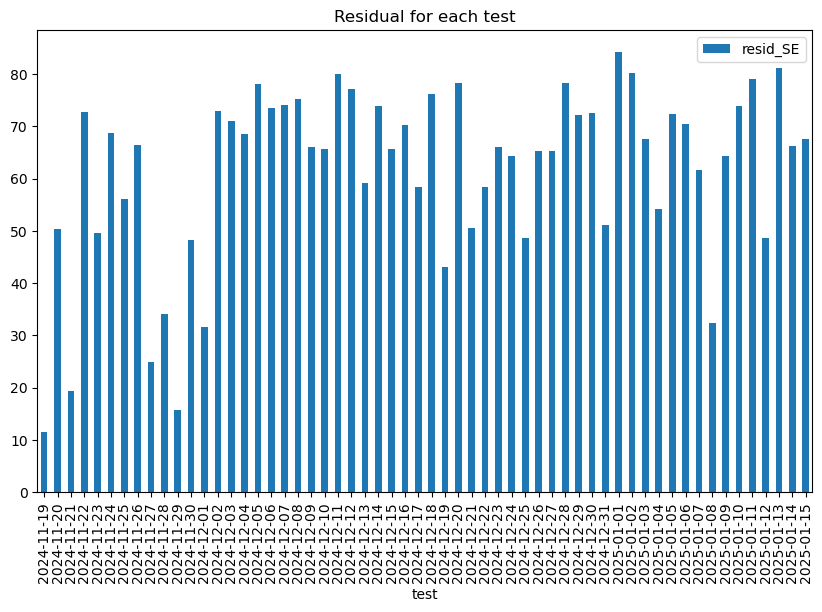

In [19]:
test_statistics.plot(x='test', y='resid_SE', kind='bar', title='Residual for each test', figsize=(10, 6))

<Axes: title={'center': 'Residual for each test'}, xlabel='test', ylabel='resid_SE'>

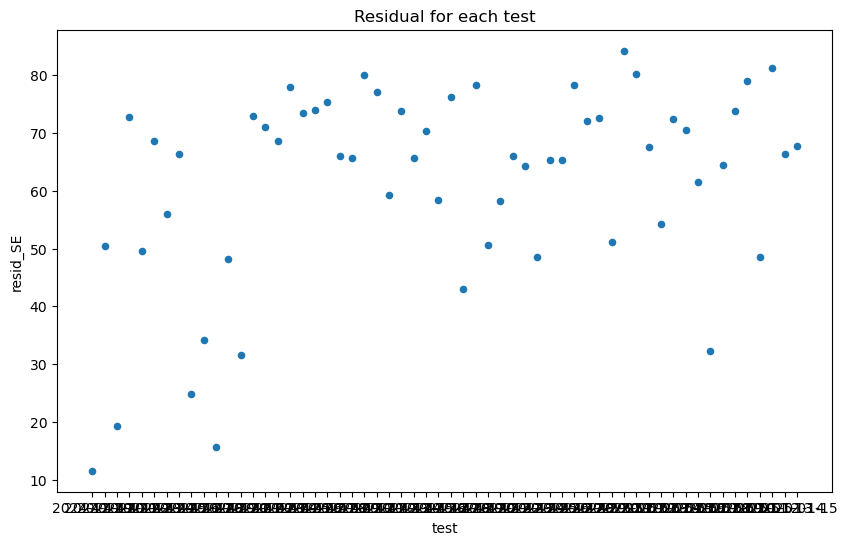

In [20]:
test_statistics.plot(x='test', y='resid_SE', kind='scatter', title='Residual for each test', figsize=(10, 6))